# Exploratory data analysis (EDA) of regulated banks

![](fdic_hq.jpeg)

## 1. Data cleaning - analysis of costs of failed banks
The dataset was retrieved on 10/22/2021 using download functionality. It contains information about recently (last 20 years) failed banks, i.e. name of the bank and IDs, date of restructuring and costs. 
* Link: https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

### 1.1 Imputing missing values of COSTS
The data set had several issues that required data cleaning and transformation. First, loading the dataset, dropping unused columns and checking missing values.

In [6]:
costs = pd.read_csv('../failure_costs/failed_banks.csv', index_col=0)
costs.drop(['FIN', 'ID', 'RESTYPE1', 'SAVR' ], axis=1, inplace=True)
costs.isnull().sum().sum()

14

It appears that 14 failed banks have NaN for restructuring costs. These missing values can be imputed either with zeros, or column average, or, even better, average % of costs to assets, as restructuring a bigger bank is more expensive. Need to check how these missing values related to the type pf resolution, RESTYPE. As shown below, there are 2 types - ASSISTANCE and FAILURE

In [7]:
costs.groupby([costs['RESTYPE']]).count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13
FAILURE,564,564,563,564,564,564,564


Comparing groupings with missing values. It appears that all 13 ASSISTANCE cases have NaN for COST and thus it is warranted to impute these values with zeros. In other words, assistance is not a failure and there are no direct costs associated with bank's restructuring in this case. There is only one ("NET FIRST NATIONAL BANK") missing value in case of an actual FAILURE and it should probably be imputed with some kind of proxy for COST.

In [8]:
missing_data = costs[costs.isnull().any(axis=1)]
missing_data.groupby([missing_data['RESTYPE']]).count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13
FAILURE,1,1,0,1,1,1,1


Using relative costs seems warranted in this case - need to compute mean of COST / QBFASSET and apply it to the bank's assets to estimate possible restructuring costs. The overall average is around 23%.

In [9]:
avg_CostsToAssets  = np.round(np.mean(costs['COST']/costs['QBFASSET']), 2)
avg_CostsToAssets

0.23

After the COST value was imputed with the multiplier `avg_CostsToAssets`:

In [10]:
costs.iloc[561, 2] = costs.iloc[561, 6] * avg_CostsToAssets
costs.iloc[561, ]

CHCLASS1                          N
CITYST               BOCA RATON, FL
COST                        7268.23
FAILDATE                 03/01/2002
NAME        NET FIRST NATIONAL BANK
QBFASSET                      37207
QBFDEP                        31601
RESTYPE                     FAILURE
Name: 26652, dtype: object

After this imputation all remaining 13 missing values are associated with assistance RESTYPE and thus should have zero COST, i.e. one can impute these missing values with zeros.

In [11]:
costs[costs.isnull().any(axis=1)].groupby("RESTYPE").count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13


In [12]:
costs['COST'].replace(np.nan, 0, inplace=True)

The resulting DataFrame `costs` does not have any missing values.

In [13]:
costs.isnull().sum().sum()

0

### 1.2 Converting and splitting FAILDATE
Column FAILDATE has information about when the bank has failed, it needs to be converted to `datetime` object and preferably split into for time series analysis.

In [14]:
costs['DATE'] = pd.to_datetime(costs['FAILDATE'])
costs.drop('FAILDATE', axis=1, inplace=True)

Split the DATE column so that information about the year and month of failure are stored in separate columns. 

In [15]:
costs['YEAR_FAILED'] = costs['DATE'].dt.year.astype('Int64')
costs['MONTH_FAILED'] = costs['DATE'].dt.month.astype('Int64')
costs['QUARTER_FAILED'] = pd.PeriodIndex(costs.DATE, freq='Q')

### 1.3 Plotting distribution and cumsum of COSTS

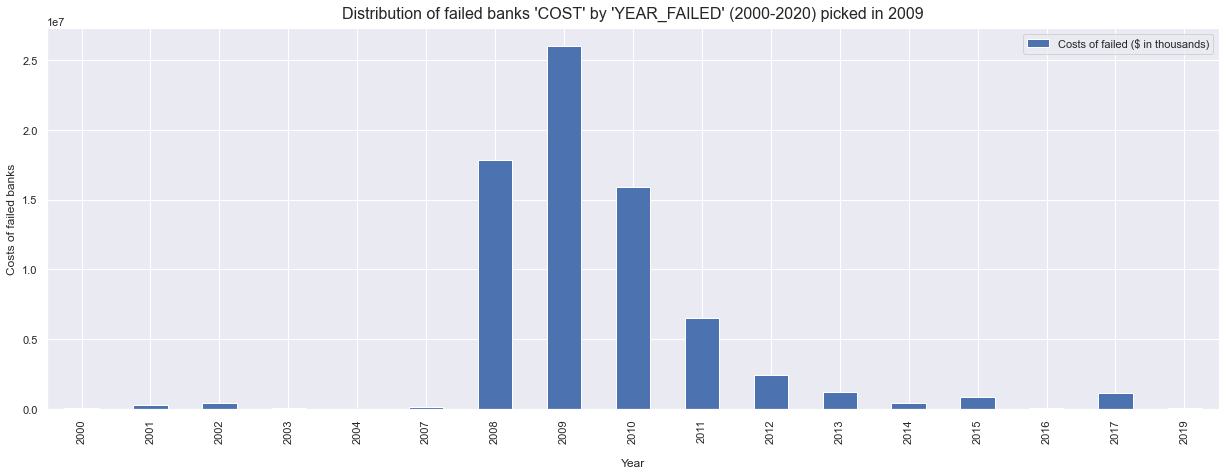

In [16]:
costs.groupby(['YEAR_FAILED'])['COST'].sum().plot(kind='bar',
                                               figsize=(21, 7),
                                               label='Costs of failed ($ in thousands)')
plt.title("Distribution of failed banks 'COST' by 'YEAR_FAILED' (2000-2020) picked in 2009", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

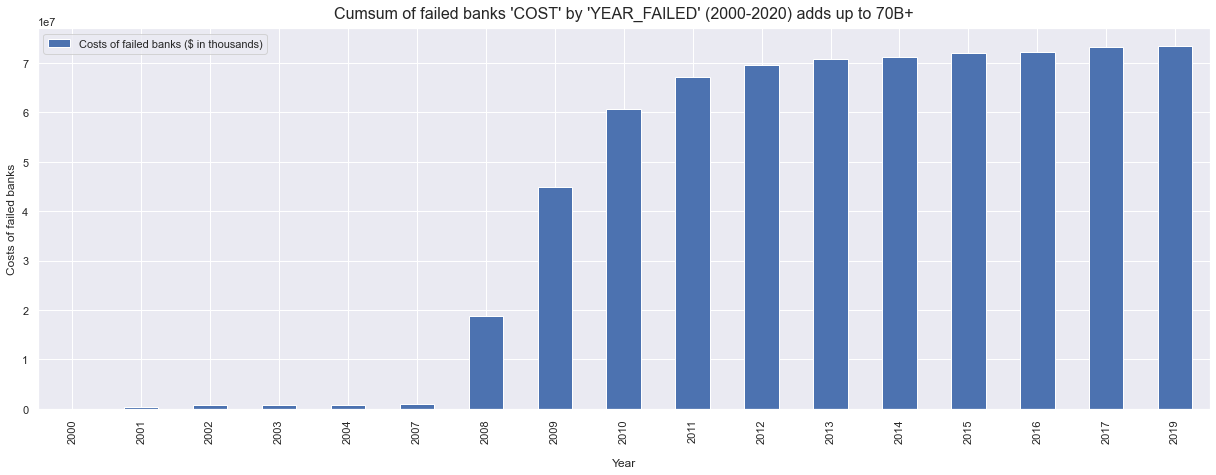

In [17]:
costs.groupby(costs['YEAR_FAILED'])['COST'].sum().cumsum(axis=0).round(2).plot(
kind='bar', figsize=(21, 7), label="Costs of failed banks ($ in thousands)")
plt.title("Cumsum of failed banks 'COST' by 'YEAR_FAILED' (2000-2020) adds up to 70B+", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

## 2. Data processing - retrieving all regulatory reports
All regulated banks submit quarterly reports to Federal Financial Institutions Examination Council (FFIEC). These data is aggregated and made available to general public via SOAP APIs. Executing sequential  `retrieve_filers_since_date` calls allows rebuilding the universe (population) of regulated banks as it existed at a specific filing date.
* Link: https://cdr.ffiec.gov/public/PWS/PWSPage.aspx
* Link: https://cdr.ffiec.gov/public/HelpFileContainers/PWSInfo.aspx

### 2.1 Connecting to the server
`FFIEC_Client` is a wrapper class written to extend functionality of a standard `zeep` SOAP APIs client. It was developed and tested in a separate .py file, imported here. All credit goes to Ryan Arredondo (ryan.c.arredondo@gmail.com) as he is the original author to the best of our knowledge.

The actual connection to the server can be done manually by entering login credentials or using the hard coded values below in the next section. FFIEC only allows a limited number of daily calls and discourages using someone else's credentials; provided for testing demonstration purposes only. 

In [18]:
from ffipy import FFIEC_Client
from io import StringIO
from zeep.wsse.username import UsernameToken
import unittest
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'ffipy'

In [ ]:
client = FFIEC_Client()

In [ ]:
client.test_user_access()

True

### 2.2 Testing reporting database client
The section below performs several unit tests on the remote server to check if the data did not change since the last retrieval.

In [ ]:
wsdl = \
    'https://cdr.ffiec.gov/Public/PWS/WebServices/RetrievalService.asmx?WSDL'
username = 'dmikhaylov2021'
password = 'zVu5W3tw4U2KAH8IeR7z'
wsse = UsernameToken(username, password)
client = FFIEC_Client(wsse=(username, password))

class API_client_rest(unittest.TestCase):
    
# Test if still connected
    def test_connected(self):
        self.assertTrue(client.test_user_access())

# Test end of the period count
    def test_end_period_count(self, date='12/31/2019', count=5227):
        self.assertEqual(len(client.retrieve_panel_of_reporters(
            ds_name='Call', reporting_pd_end=date)), count)

# Test start of the period count
    def test_start_period_count(self, date='12/31/2001', count=8689):
        self.assertEqual(len(client.retrieve_panel_of_reporters(
            ds_name='Call', reporting_pd_end=date)), count)
    
# Test name of the bank
    def test_reporting_periods(self, report_type='Call', periods=83):
        self.assertEqual(len(client.retrieve_reporting_periods(ds_name=report_type)), periods)

if __name__ == "__main__":

  unittest.main(argv=[''], exit=False)

./Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=67, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58807)>

/Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58954)>

/Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58955)>

/Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58963)>

/Us

### 2.3 Comparing failed and surviving banks
Get the number of regulator reports submitted by the banks and compare the number of surviving banks to the number of failed banks at the end of the same period. 

First, get the list of years for which there are costs of failures data. After that, make API calls for end of these years to check how many banks submitted the reports. Store the results on `regulated_universe` dictionary. This may take several minutes to run.

In [19]:
years = costs['YEAR_FAILED'].unique()
regulated_universe = {}
for year in years:
    reporting_date = '12/31/'+str(year)
    try:
        regulated_universe[year]=len(client.retrieve_panel_of_reporters(ds_name='Call', 
                                                                        reporting_pd_end=reporting_date))
    except:
        regulated_universe[year] = 0
regulated_universe

{2019: 0,
 2017: 0,
 2016: 0,
 2015: 0,
 2014: 0,
 2013: 0,
 2012: 0,
 2011: 0,
 2010: 0,
 2009: 0,
 2008: 0,
 2007: 0,
 2004: 0,
 2003: 0,
 2002: 0,
 2001: 0,
 2000: 0}

Code below stores information about failed and active, i.e. surviving or reporting, banks in a single DataFrame object for the purposes of visualization and analysis. First, `groupby` selection of annual failed banks is converted to a separate table `failed_counts`, sorted, and columns renamed. Second, `active_counts` table is produced from the `regulated_universe` dictionary returned by API client. Finally, both tables are merged on column "Year" for further analysis.

In [20]:
failed_counts = costs.groupby(costs['YEAR_FAILED'])['COST'].count().reset_index().rename(
    columns={'YEAR_FAILED':'Year', 'COST':'Failed'})
failed_counts.sort_values('Year', ascending=True, inplace=True)

active_counts = pd.DataFrame.from_dict(regulated_universe, orient='index', columns=['Active']).reset_index()
active_counts.sort_values('index', ascending=True, inplace=True)

banks_counts = pd.merge(active_counts, failed_counts, how="inner", on=failed_counts['Year'])

Below is a summary plot that shows annual counts of failed banks stacked on top of active banks. Please note that y-axis was adjust for a range starting at 4000 counts to make failed banks appear more pronounced.

Still, bank failures is a very rare event that obviously can't explain why the number of regulated banks declined from almost 9,000 down to slightly more than 5,000. Additional analysis is warranted to help understand the drivers of this drastic change.

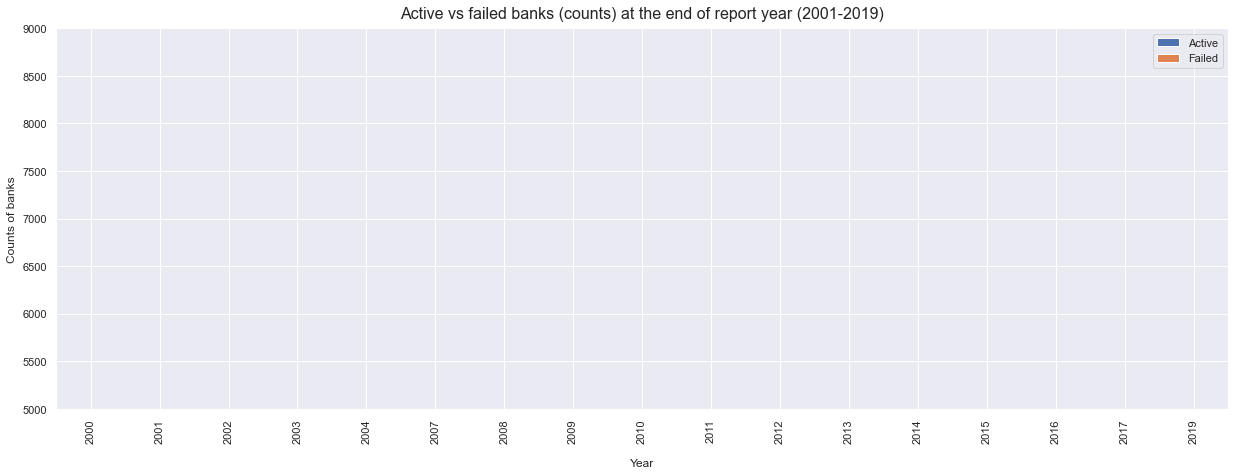

In [21]:
banks_counts.plot(x='Year', 
                  y=['Active', 'Failed'], 
                  kind='bar', 
                  stacked=True, 
                  figsize=(21, 7))

plt.legend()
plt.title("Active vs failed banks (counts) at the end of report year (2001-2019)", y=1.01, fontsize=16)
plt.ylabel("Counts of banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.ylim([5000, 9000])
plt.show()

## 3. Data analysis - explaining industry consolidation 
FDIC maintains BankFind Suite portal, which is effectively events and changes database. Although it does not redirect to the corresponding statutory reports, it provides summary information about major corporate events, such as mergers or charter changes.
- Link: https://banks.data.fdic.gov/bankfind-suite/oscr

In [26]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "seaborn"

### 3.1 HOW MUCH TO EXPLAIN AT THIS POINT REGARDING OUR RECONCILIATION EFFORTS???

In [27]:
def FilterDF(df, cols_keep, date_col, class_col, filter_criteria={}, start_year=2000, end_year=2020):
    """
    Function cleans data from the FDIC CSVs on changing Cert IDs.

    It only keeps desired columns, will filter based on additional criteria, and will only keep
    entries within the desired date range + are Commercial Banks / Savings Institutions
    """

    # Ensure Correct Data Types
    if type(cols_keep) != list:
        cols_keep = [cols_keep]

    # Extract Desired Columns
    df_clean = df[cols_keep].copy()
    
    # Convert Date Column to DateTime
    df_clean[date_col] = pd.to_datetime(df_clean[date_col])

    # Filter Date Column To Desired Range (2000-2020 defualt)
    df_clean = df_clean.loc[(df_clean[date_col].dt.year >= start_year) & 
                            (df_clean[date_col].dt.year <= end_year)]

    # Filter Anything Not Needed
    if filter_criteria != {}:
        for key in filter_criteria.keys():
            df_clean = df_clean.loc[df_clean[key] == filter_criteria[key]]

    # Filter Class Type != Savings or Commercial
    df_clean = df_clean.loc[(df_clean[class_col] == 'Savings') |
                            (df_clean[class_col] == 'Commercial')
                            ].reset_index(drop=True)

    
    return df_clean

In [28]:
def CountByYear(df, class_col, date_col, count_col):
    """
    Function takes clean data from the FDIC CSVs on changing Cert IDs and obtains the counts by year.
    """

    # Count Cert IDs by Year
    df_by_year = df.groupby([class_col, df[date_col].dt.year]).count()[count_col].reset_index()
    df_by_year.columns = ['Class Type', 'Year', 'Count']

    # Fill in Missing Years
    for year in range(2000, 2021):
        temp_com = df_by_year.loc[(df_by_year['Year'] == year) &
                                  (df_by_year['Class Type'] == 'Commercial')]
        temp_sav = df_by_year.loc[(df_by_year['Year'] == year) &
                                  (df_by_year['Class Type'] == 'Savings')]
        if len(temp_com) != 1:
            df_by_year = df_by_year.append({'Class Type': 'Commercial', 'Year': year, 'Count': 0}, ignore_index=True)
        if len(temp_sav) != 1:
            df_by_year = df_by_year.append({'Class Type': 'Savings', 'Year': year, 'Count': 0}, ignore_index=True)

    # Sort DataFrame
    df_by_year = df_by_year.sort_values(by=['Class Type', 'Year']).reset_index(drop=True)

    # Reformat DataFrame
    df_by_year_reformat = pd.DataFrame(df_by_year.loc[df_by_year['Class Type'] == 'Commercial', 'Year'])
    df_by_year_reformat['Commercial'] = list(df_by_year.loc[df_by_year['Class Type'] == 'Commercial', 'Count'])
    df_by_year_reformat['Savings'] = list(df_by_year.loc[df_by_year['Class Type'] == 'Savings', 'Count'])

    return df_by_year_reformat

In [29]:
def GenerateHistogram(df, category, start_year=2000, end_year=2020):
    """
    Function takes the counts by year of Commercial Banks and Savings Institutions for any change type
    and produces a histogram view of the desired years.
    """
    
    # Generate Figure
    fig, axis = plt.subplots(figsize=(24, 10))

    # Filter Year to Desired Time Frame
    df = df.loc[(df['Year'] >= start_year) & (df['Year'] <= end_year)
               ].reset_index(drop=True).copy()

    # Plot
    df.plot(kind='bar', x='Year', ax=axis)

    # Label Plot
    axis.set_ylabel(f'Count of {category}', size=16)
    axis.set_xlabel('Year', size=16)
    axis.set_title(f'{category} by Year', size=22)
    axis.tick_params(axis='x', labelsize=13, labelrotation=0)
    axis.tick_params(axis='y', labelsize=13)
    axis.legend(fontsize=16)

    # Write Counts Above Bars
    for i, v in enumerate(df['Commercial']):
        axis.text(i-0.123, 1.01*v, str(v), color='blue', fontweight='bold', horizontalalignment='center')
    for i, v in enumerate(df['Savings']):
        axis.text(i+0.123, 1.01*v, str(v), color='orange', fontweight='bold', horizontalalignment='center')

    # Show Figure
    fig.show()

In [35]:
# Load Individual Cert Change Datasets
new_institutions = pd.read_csv("../../data/New_Institutions_10_21_2021.csv")
liquidations = pd.read_csv('../../data/Liquidations_10_21_2021.csv')
combinations = pd.read_csv('../../data/Business_Combinations_10_21_2021.csv')
failures = pd.read_csv('../../data/Business_Combinations_-_Failures_10_21_2021.csv')

# Load Summary Tables
commercial_banks_sum = pd.read_csv('../../data/cb_structure.csv')
savings_institutions_sum = pd.read_csv('../../data/si_structure.csv')

savings_institutions_sum.head()

,ID,SAVINGS,STNAME,YEAR,alsonew,chartoth,chrtrest,comboass,combos,newcount,tofail,tomerg,tortc
0,SI_1999_USA,1639,United States & Other Areas,1999,0,6,24,1,34,36,0,22,0
1,SI_2000_USA,1587,United States & Other Areas,2000,0,4,45,0,28,30,0,8,0
2,SI_2001_USA,1530,United States & Other Areas,2001,0,3,57,1,32,16,0,11,0
3,SI_2002_USA,1469,United States & Other Areas,2002,0,2,10,0,28,1,0,8,0
4,SI_2003_USA,1411,United States & Other Areas,2003,0,2,14,0,24,5,0,13,0


In [31]:
ni = FilterDF(new_institutions, ['CERT', 'FRM_CLASS_TYPE_DESC', 'EFFDATE'], 'EFFDATE', 'FRM_CLASS_TYPE_DESC')
li = FilterDF(liquidations, ['CERT', 'FRM_CLASS_TYPE_DESC', 'EFFDATE', 'CHANGECODE_DESC'], 'EFFDATE', 
         'FRM_CLASS_TYPE_DESC', filter_criteria={'CHANGECODE_DESC': 'FINANCIAL DIFFICULTY - PAYOFF'})
co = FilterDF(combinations, ['CERT', 'ACQ_CLASS_TYPE_DESC', 'EFFDATE'], 'EFFDATE', 'ACQ_CLASS_TYPE_DESC')
fa = FilterDF(failures, ['CERT', 'ACQ_CLASS_TYPE_DESC', 'EFFDATE'], 'EFFDATE', 'ACQ_CLASS_TYPE_DESC')

ni.head(10)

,CERT,FRM_CLASS_TYPE_DESC,EFFDATE
0,34619,Commercial,2000-01-01
1,35417,Commercial,2000-01-01
2,35347,Commercial,2000-01-03
3,35355,Commercial,2000-01-10
4,35033,Commercial,2000-01-10
5,35295,Commercial,2000-01-10
6,35394,Savings,2000-01-12
7,35296,Commercial,2000-01-14
8,34951,Commercial,2000-01-18
9,35324,Commercial,2000-01-18


In [32]:
ni_cnts = CountByYear(ni, 'FRM_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')
li_cnts = CountByYear(li, 'FRM_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')
co_cnts = CountByYear(co, 'ACQ_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')
fa_cnts = CountByYear(fa, 'ACQ_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')

ni_cnts.head(10)

,Year,Commercial,Savings
0,2000,190,33
1,2001,127,18
2,2002,91,3
3,2003,110,7
4,2004,122,6
5,2005,167,14
6,2006,179,16
7,2007,176,17
8,2008,91,8
9,2009,29,8


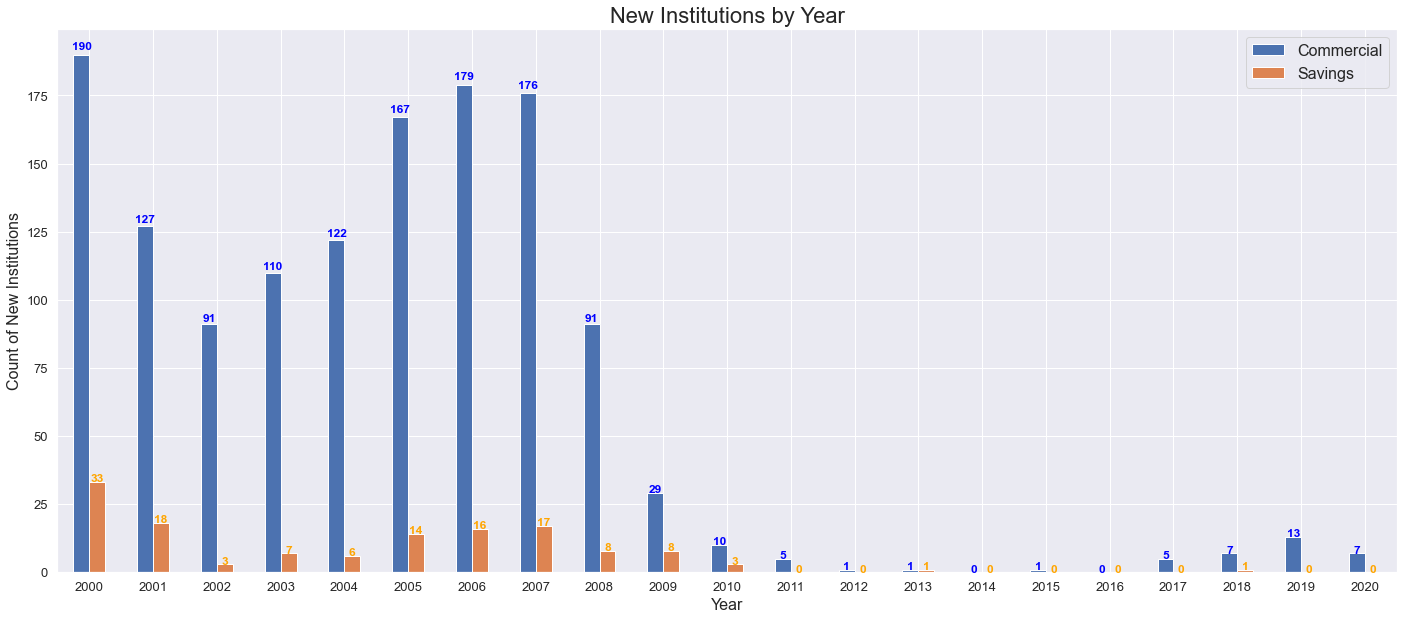

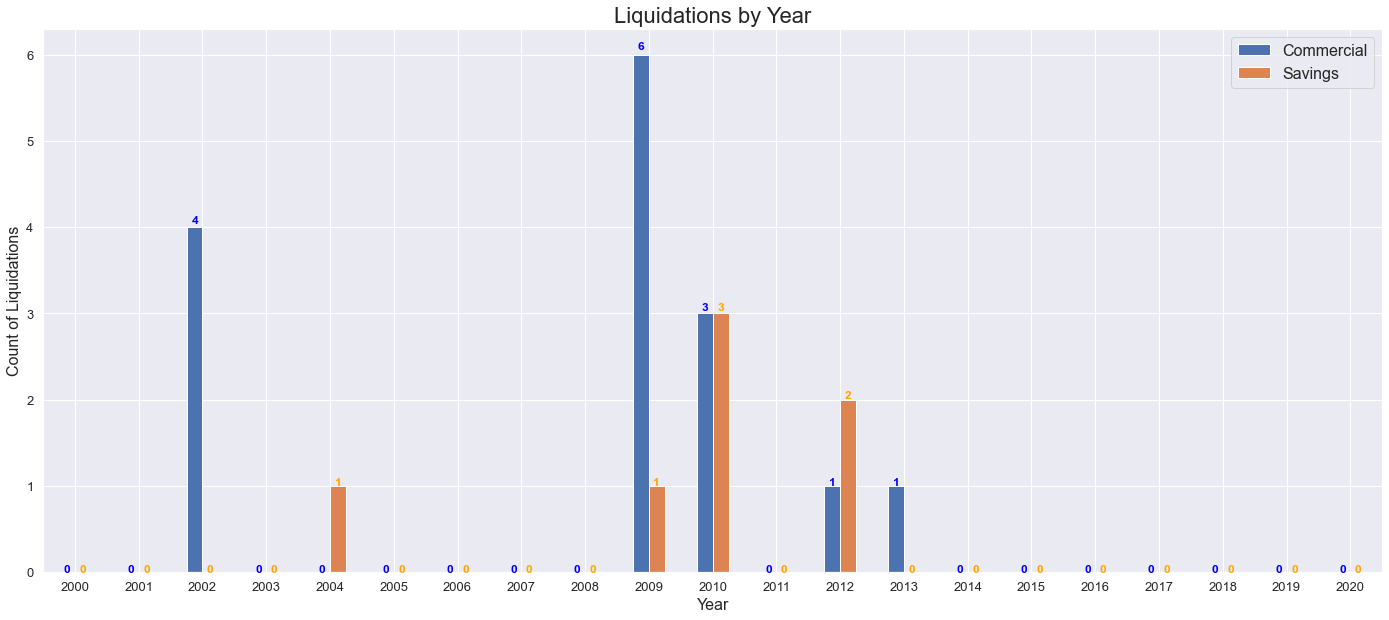

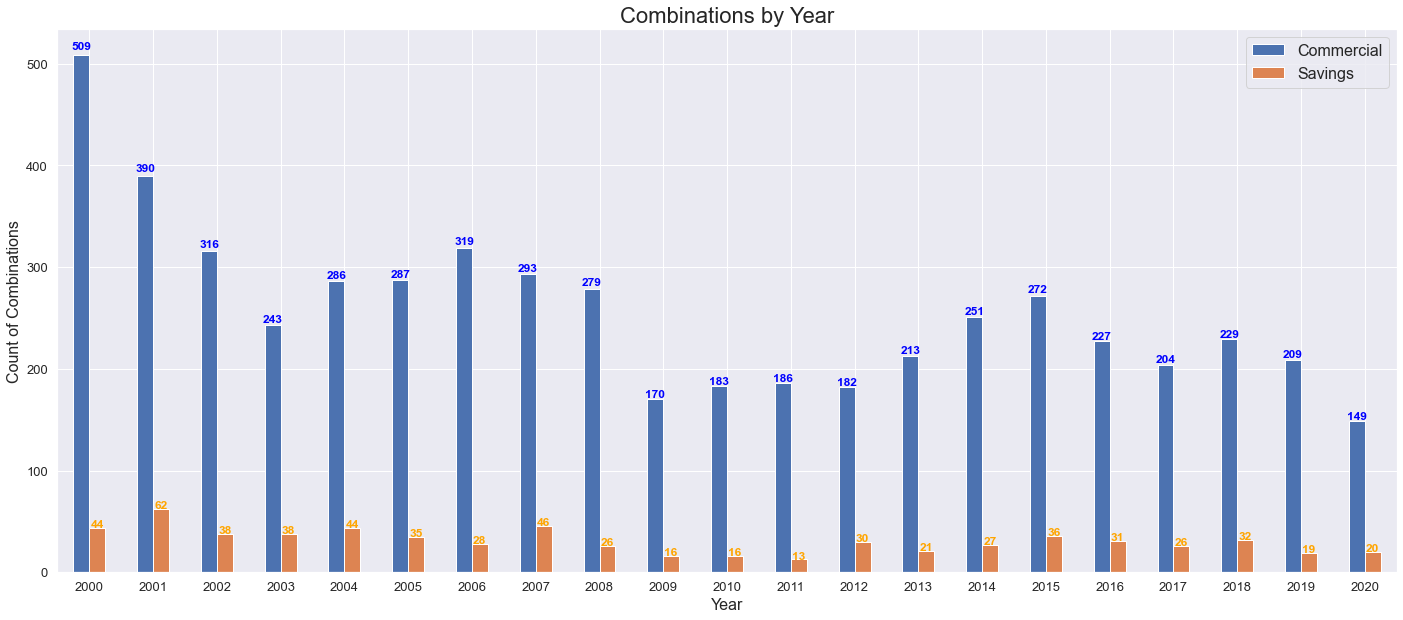

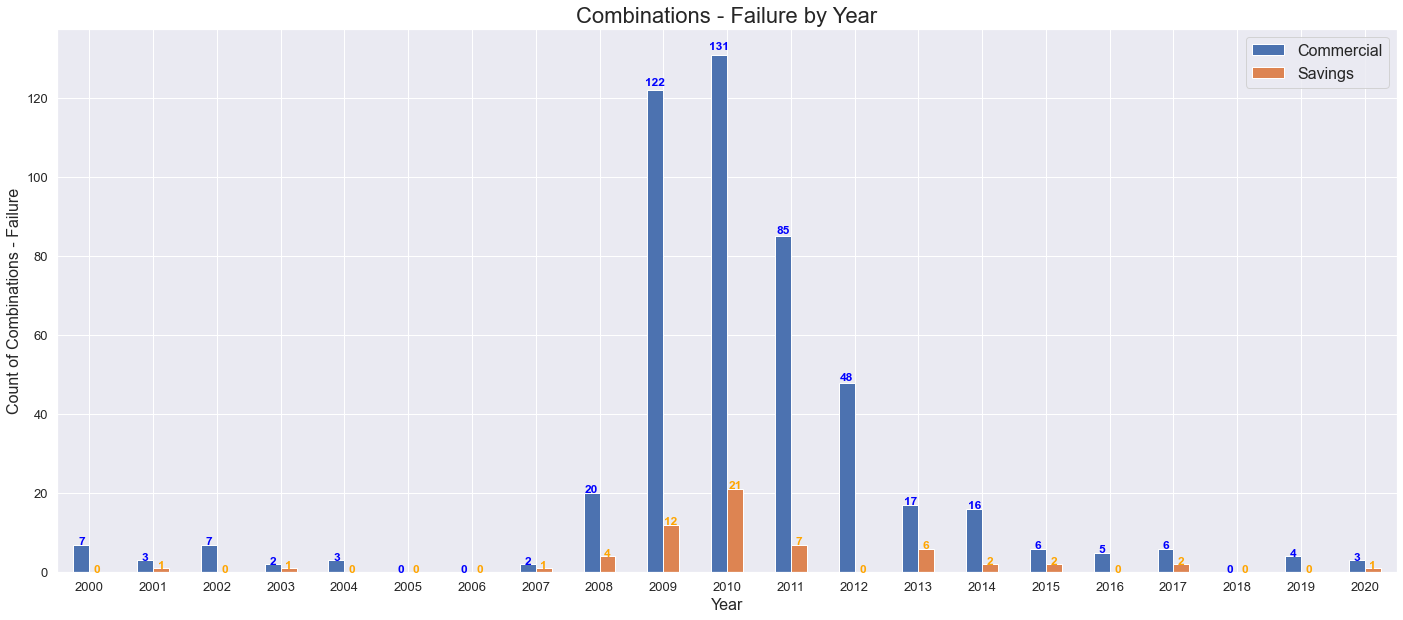

In [33]:
GenerateHistogram(ni_cnts, 'New Institutions')
GenerateHistogram(li_cnts, 'Liquidations')
GenerateHistogram(co_cnts, 'Combinations')
GenerateHistogram(fa_cnts, 'Combinations - Failure')

### 3.2 Summary waterfall chart
This chart is a querying tool as well. It not only gives a high level view of the industry consolidation throughout the years but also allows to do visual analysis of the data by zooming into desired flows and periods. use 'Reset axes' to go back to the original view.

In [37]:
def CombineChangesByYear(summary_com, summary_sav, new_institutions, conversions, conversions_failed, liquidations, combine=False):

    # Combine Commercial Banks + Savings Institutions
    if combine:

        # Initialize with the starting value
        total_end = int(summary_com[summary_com['YEAR'] == 2000]['TOTAL']) + \
                        int(summary_sav[summary_sav['YEAR'] == 2000]['SAVINGS'])
        data = [[f'2000 Total', total_end, 'absolute', 'Year Start']]

        for year in range(2000, 2020):

            # Generate the total counts for each year
            total_ni = int(new_institutions[new_institutions['Year'] == year]['Commercial']) + \
                         int(new_institutions[new_institutions['Year'] == year]['Savings'])
            total_co = int(conversions[conversions['Year'] == year]['Commercial']) + \
                         int(conversions[conversions['Year'] == year]['Savings'])
            total_fa = int(conversions_failed[conversions_failed['Year'] == year]['Commercial']) + \
                         int(conversions_failed[conversions_failed['Year'] == year]['Savings'])
            total_li = int(liquidations[liquidations['Year'] == year]['Commercial']) + \
                         int(liquidations[liquidations['Year'] == year]['Savings'])

            # Make Adjustments
            total_start = total_end
            total_end = int(summary_com[summary_com['YEAR'] == year+1]['TOTAL']) + \
                             int(summary_sav[summary_sav['YEAR'] == year+1]['SAVINGS'])
            total_adj = total_start - total_end + total_ni - total_co - total_fa - total_li

            # Put counts into individual rows
            data_year = [
                [f'{year} New Institutions', total_ni, 'relative', 'New Institutions'],
                [f'{year} Combinations', -total_co, 'relative', 'Combinations'], 
                [f'{year} Failures', -total_fa, 'relative', 'Combinations of Failed Bank'], 
                [f'{year} Liquidations', -total_li, 'relative', 'Liquidations'], 
                [f'{year} Adjustments', -total_adj, 'relative', 'All Other Adjustments'],
                [f'{year+1} Total', 0, 'total', 'Year Start']
                        ]

            # Add year to aggregate data
            data.extend(data_year)

        # Create DataFrame with event counts by year
        df = pd.DataFrame(columns = ['Category', 'Value', 'Measure Type', 'Text'], data = data)
            
        return df

    # Calculate Commercial Banks + Savings Institutions Seperately
    else:

        # Initialize with the starting values
        total_end_com = int(summary_com[summary_com['YEAR'] == 2000]['TOTAL'])
        total_end_sav = int(summary_sav[summary_sav['YEAR'] == 2000]['SAVINGS'])
        data_com = [[f'2000 Total', total_end_com, 'absolute', 'Year Start']]
        data_sav = [[f'2000 Total', total_end_sav, 'absolute', 'Year Start']]
        
        for year in range(2000, 2020):

            # Generate the total counts for each year
            total_ni_com = int(new_institutions[new_institutions['Year'] == year]['Commercial'])
            total_ni_sav = int(new_institutions[new_institutions['Year'] == year]['Savings'])
            total_co_com = int(conversions[conversions['Year'] == year]['Commercial'])
            total_co_sav = int(conversions[conversions['Year'] == year]['Savings'])
            total_fa_com = int(conversions_failed[conversions_failed['Year'] == year]['Commercial'])
            total_fa_sav = int(conversions_failed[conversions_failed['Year'] == year]['Savings'])
            total_li_com = int(liquidations[liquidations['Year'] == year]['Commercial'])
            total_li_sav = int(liquidations[liquidations['Year'] == year]['Savings'])

            # Make Adjustments
            total_start_com = total_end_com
            total_start_sav = total_end_sav
            total_end_com = int(summary_com[summary_com['YEAR'] == year+1]['TOTAL'])
            total_end_sav = int(summary_sav[summary_sav['YEAR'] == year+1]['SAVINGS'])
            total_adj_com = total_start_com - total_end_com + total_ni_com - total_co_com - total_fa_com - total_li_com
            total_adj_sav = total_start_sav - total_end_sav + total_ni_sav - total_co_sav - total_fa_sav - total_li_sav

            # Put counts into individual rows
            data_year_com = [
                [f'{year} New Institutions', total_ni_com, 'relative', 'New Institutions'],
                [f'{year} Combinations', -total_co_com, 'relative', 'Combinations'], 
                [f'{year} Failures', -total_fa_com, 'relative', 'Combinations of Failed Bank'], 
                [f'{year} Liquidations', -total_li_com, 'relative', 'Liquidations'], 
                [f'{year} Adjustments', -total_adj_com, 'relative', 'All Other Adjustments'],
                [f'{year+1} Total', 0, 'total', 'Year Start']
                        ]
            data_year_sav = [
                [f'{year} New Institutions', total_ni_sav, 'relative', 'New Institutions'],
                [f'{year} Combinations', -total_co_sav, 'relative', 'Combinations'], 
                [f'{year} Failures', -total_fa_sav, 'relative', 'Combinations of Failed Bank'], 
                [f'{year} Liquidations', -total_li_sav, 'relative', 'Liquidations'], 
                [f'{year} Adjustments', -total_adj_sav, 'relative', 'All Other Adjustments'],
                [f'{year+1} Total', 0, 'total', 'Year Start']
                        ]

            # Add year to aggregate data
            data_com.extend(data_year_com)
            data_sav.extend(data_year_sav)

        # Create DataFrame with event counts by year
        df_com = pd.DataFrame(columns = ['Category', 'Value', 'Measure Type', 'Text'], data = data_com)
        df_sav = pd.DataFrame(columns = ['Category', 'Value', 'Measure Type', 'Text'], data = data_sav)

        return df_com, df_sav


,Category,Value,Measure Type,Text
0,2000 Total,9787,absolute,Year Start
1,2000 New Institutions,223,relative,New Institutions
2,2000 Combinations,-553,relative,Combinations
3,2000 Failures,-7,relative,Combinations of Failed Bank
4,2000 Liquidations,0,relative,Liquidations
...,...,...,...,...
116,2019 Combinations,-228,relative,Combinations
117,2019 Failures,-4,relative,Combinations of Failed Bank
118,2019 Liquidations,0,relative,Liquidations
119,2019 Adjustments,41,relative,All Other Adjustments


In [ ]:
# Get data inputs for Waterfall Chart
waterfall_df_all = CombineChangesByYear(commercial_banks_sum, savings_institutions_sum, ni_cnts, co_cnts, fa_cnts, li_cnts, True)
waterfall_df_com, waterfall_df_sav =  CombineChangesByYear(commercial_banks_sum, savings_institutions_sum, ni_cnts, co_cnts, fa_cnts, li_cnts, False)

waterfall_df_all.head(10)

In [38]:
data = waterfall_df_com.copy()
x = data['Category']
y = data['Value']
measure = data['Measure Type']
fig = go.Figure(go.Waterfall(measure=measure, x=x, y=y))
fig.update_layout(title="Commercial banks consolitation 2000-2020",
                  xaxis = go.layout.XAxis(tickangle = 270))
fig.update_yaxes(range=[4000, 8500])

### 3.3 - Validate User Input for GUI

In [55]:
def ValidateInputYears(minyear, maxyear):
    try:
        min = int(minyear)
        max = int(maxyear)
    except:
        raise TypeError()

    if min < 2000 or max < 2000 or min > 2020 or max > 2020:
        raise ValueError()
    elif max < min:
        raise ValueError()

    return min, max

In [56]:
import unittest

class UserInputsTest(unittest.TestCase):

    def test_nan_inputs(self):

        # Looking for Type Errors
        with self.assertRaises(TypeError): ValidateInputYears('', '')
        with self.assertRaises(TypeError): ValidateInputYears('Five', 'Two')
        with self.assertRaises(TypeError): ValidateInputYears('2010', '')
        with self.assertRaises(TypeError): ValidateInputYears('', '2010')
        with self.assertRaises(TypeError): ValidateInputYears('abc', 'def')

    def test_out_of_range_inputs(self):

        # Looking for Value Errors
        with self.assertRaises(ValueError): ValidateInputYears('1999', '2010')
        with self.assertRaises(ValueError): ValidateInputYears('2000', '2021')
        with self.assertRaises(ValueError): ValidateInputYears('1800', '2200')

    def test_min_max_combo_inputs(self):

        # Looking for Value Error
        with self.assertRaises(ValueError): ValidateInputYears('2010', '2000')

    def test_valid_inputs(self):

        # Set Up
        min1, max1 = ValidateInputYears('2000', '2020')
        min2, max2 = ValidateInputYears('2005', '2008')
        min3, max3 = ValidateInputYears('2010', '2010')

        # Test Valid Inputs
        self.assertEqual(min1, 2000)
        self.assertEqual(min2, 2005)
        self.assertEqual(min3, 2010)
        self.assertEqual(max1, 2020)
        self.assertEqual(max2, 2008)
        self.assertEqual(max3, 2010)


unittest.main(argv=[''], exit = False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.009s

OK


## Conclusions future improvements